# Descarga del dataset que contiene los archivos .WAV para el entrenamiento y testing

In [ ]:
import math
import json
import librosa
import os
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
!kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification
!unzip gtzan-dataset-music-genre-classification
!rm -r gtzan-dataset-music-genre-classification.zip

 98% 1.19G/1.21G [00:29<00:00, 38.3MB/s]
100% 1.21G/1.21G [00:29<00:00, 43.5MB/s]
Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_origi

# Funcion que se encarga de convertir los archivos de audio en espectrogramas

In [ ]:
def preprocess(dataset_path,num_mfcc=40,n_fft=2048,hop_length=512,num_segment=10):
  data = {"labels":[],"mfcc":[]}
  sample_rate = 22050
  samples_per_segment=int(sample_rate*30/num_segment)
  for label_idx, (dirpath,dirnames,filenames)in enumerate(os.walk(dataset_path)):
    if dirpath == dataset_path:
      continue
               
    for f in sorted(filenames):
      if not f.endswith('.wav'):
        continue
      file_path=str(str(dirpath).split('\\')[-1])+"/"+str(f)
      print("Track Name",file_path)
      try:
       y,sr=librosa.load(file_path,sr=sample_rate)
      except:
        continue
      for n in range(num_segment):
        mfcc = librosa.feature.mfcc(y[samples_per_segment*n:samples_per_segment*(n+1)],
                                    sample_rate, n_mfcc = num_mfcc, n_fft = n_fft,
                                    hop_length = hop_length)
        mfcc = mfcc.T
        if len(mfcc)== math.ceil(samples_per_segment/hop_length):
          data["mfcc"].append(mfcc.tolist())
          data["labels"].append(label_idx-1)
  return data

# Inicia el modelo y entrenamiento de la red neuronal convolucional

In [ ]:
import cv2
def load_image_data(img_folder):
  X=[]
  y=[]
  for genre_folder in os.listdir(img_folder):
    X = X + [cv2.imread(os.path.join(img_folder,genre_folder,curr_file))
              for curr_file in os.listdir(os.path.join(img_folder, genre_folder))]
    y = y + [genre_folder]*len(os.listdir(os.path.join(img_folder, genre_folder)))
  
  return np.array(X),np.array(y)
                                                                    

In [ ]:
%%time
X_img,y_img = load_image_data('/content/Data/images_original')

CPU times: user 1.95 s, sys: 751 ms, total: 2.7 s
Wall time: 2.71 s


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_img = label_encoder.fit_transform(y_img)
x_train, x_test, y_train, y_test = train_test_split(X_img,y_img,test_size = 0.2,random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.2,random_state=42)                                                       

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense
from tensorflow.keras.optimizers import Adam

image_model=None
image_model=Sequential()
image_model.add(Conv2D(128,3,padding="same",activation="relu", input_shape = (288, 432, 3)))
image_model.add(MaxPool2D())

image_model.add(Conv2D(64,3,padding="same",activation="relu"))
image_model.add(MaxPool2D())

image_model.add(Conv2D(32,3,padding="same",activation="relu"))
image_model.add(MaxPool2D())

image_model.add(Conv2D(32,3,padding="same",activation="relu"))
image_model.add(MaxPool2D())
image_model.add(Dropout(0.2))

image_model.add(Flatten())
image_model.add(Dense(128,activation="relu"))
image_model.add(Dense(10,activation="softmax"))


image_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 288, 432, 128)     3584      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 144, 216, 128)    0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 144, 216, 64)      73792     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 72, 108, 64)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 108, 32)       18464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 54, 32)      

In [ ]:
opt=Adam(lr=0.0001)
image_model.compile(optimizer = opt,
                    loss='sparse_categorical_crossentropy',
                    metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history=image_model.fit(x_train,y_train,
                          epochs = 100,
                          validation_data=(x_val,y_val),
                          batch_size=32,
                          verbose=2)

Epoch 1/100
20/20 - 21s - loss: 10.6302 - accuracy: 0.1502 - val_loss: 2.7542 - val_accuracy: 0.1187 - 21s/epoch - 1s/step
Epoch 2/100
20/20 - 6s - loss: 2.5836 - accuracy: 0.1862 - val_loss: 2.1079 - val_accuracy: 0.2438 - 6s/epoch - 296ms/step
Epoch 3/100
20/20 - 6s - loss: 2.0740 - accuracy: 0.2723 - val_loss: 1.9763 - val_accuracy: 0.3187 - 6s/epoch - 292ms/step
Epoch 4/100
20/20 - 6s - loss: 1.8288 - accuracy: 0.3568 - val_loss: 1.7304 - val_accuracy: 0.3875 - 6s/epoch - 293ms/step
Epoch 5/100
20/20 - 6s - loss: 1.6740 - accuracy: 0.3897 - val_loss: 1.7754 - val_accuracy: 0.3938 - 6s/epoch - 297ms/step
Epoch 6/100
20/20 - 6s - loss: 1.4137 - accuracy: 0.5070 - val_loss: 1.5557 - val_accuracy: 0.3750 - 6s/epoch - 299ms/step
Epoch 7/100
20/20 - 6s - loss: 1.1866 - accuracy: 0.5947 - val_loss: 1.6559 - val_accuracy: 0.4062 - 6s/epoch - 299ms/step
Epoch 8/100
20/20 - 6s - loss: 1.0509 - accuracy: 0.6588 - val_loss: 1.4274 - val_accuracy: 0.4563 - 6s/epoch - 299ms/step
Epoch 9/100
20/2

# Resultados del modelo

In [ ]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Audio
from matplotlib.pyplot import imshow

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


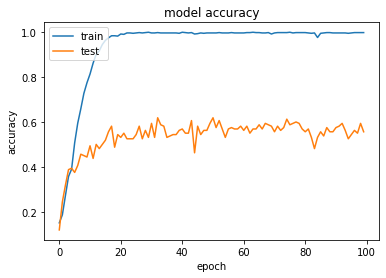

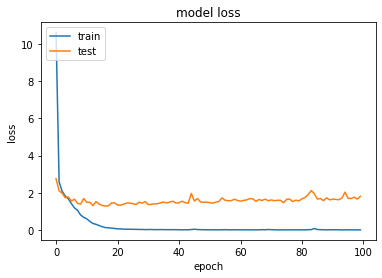

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

img = image.load_img('Data/images_original/blues/blues00000.png')

img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

img_preprocessed = preprocess_input(img_batch)

prediction = image_model.predict(img_preprocessed)

print(prediction)

[[1.1238166e-13 1.0205271e-33 2.7644249e-33 3.5125462e-20 1.8343960e-09
  1.6430990e-07 0.0000000e+00 9.3907217e-13 9.9999988e-01 3.2529219e-23]]
